In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
import re
import os
import ast
import wandb
import string
import numpy as np
import unicodedata
import pandas as pd
from pathlib import Path
from datasets import load_dataset
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import flash_attn
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import EarlyStoppingCallback
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import sys
sys.path.append("../../src")
sys.path.append("../../configs")
import util.preprocessing_util as util
from hf_config import hf_token

# Setup

Check versions of important packages

In [106]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Flash Attention version:", flash_attn.__version__)

PyTorch version: 2.6.0+cu124
CUDA version: 12.4
Flash Attention version: 2.7.4.post1


Check which python we are using

In [107]:
print(sys.executable)

/share/miniforge3/bin/python3.10


# Load Data

In [108]:
input_data_path = Path("../../data/dev/processed")

In [109]:
train_df = pd.read_csv(input_data_path / "emrqa-msquad_train.csv")
test_df = pd.read_csv(input_data_path / "emrqa-msquad_test.csv")

Sentences and labels are still stringified lists --> back to actual Python lists

In [110]:
# Apply literal_eval to parse strings into actual lists
train_df["sentences"] = train_df["sentences"].apply(ast.literal_eval)
train_df["labels"] = train_df["labels"].apply(ast.literal_eval)

test_df["sentences"] = test_df["sentences"].apply(ast.literal_eval)
test_df["labels"] = test_df["labels"].apply(ast.literal_eval)

In [111]:
train_df.head()

,question,context,sentences,labels
0,1010 abdominal pain meds on in past,this is a 59yearold female with a history of r...,[this is a 59yearold female with a history of ...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,325insulin 7030,the 62m with a history of cad and prior mi lea...,[the 62m with a history of cad and prior mi le...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
2,a bacterial urinary tract infection meds on in...,the patient is a 70yearold woman with a histor...,[the patient is a 70yearold woman with a histo...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,a decompensated heart failure meds on in past,this is a 70yearold woman with ischemic cardio...,[this is a 70yearold woman with ischemic cardi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,a flutter with hr in the 110s meds on in past,lucien lebel an 88975183 patient was admitted ...,[lucien lebel an 88975183 patient was admitted...,"[0, 0, 1, 0, 0]"


In [112]:
print(f"Number of samples: {len(train_df)}")

Number of samples: 124414


# Sentence Masking

We’ll create one row per sentence: full context + label for only that sentence

And add [START] and [END] markers around the target sentence

In [113]:
WINDOW_SIZE = 2

In [114]:
train_df = util.mask_on_sentence_level(train_df, window=WINDOW_SIZE)
test_df = util.mask_on_sentence_level(test_df, window=WINDOW_SIZE)

In [115]:
train_df.head()

,question,context,target_sentence,target_index,label
0,1010 abdominal pain meds on in past,[START] this is a 59yearold female with a hist...,this is a 59yearold female with a history of r...,0,0
1,1010 abdominal pain meds on in past,this is a 59yearold female with a history of r...,she was given recent levaquin for an upper res...,1,0
2,1010 abdominal pain meds on in past,this is a 59yearold female with a history of r...,she complained of 1010 abdominal pain and was ...,2,1
3,1010 abdominal pain meds on in past,she was given recent levaquin for an upper res...,her hematocrit at one point required two units...,3,0
4,1010 abdominal pain meds on in past,she complained of 1010 abdominal pain and was ...,she was discharged on diltiazem 30 mg qid,4,0


In [116]:
print(f"Number of samples: {len(train_df)}")

Number of samples: 2220141


# Downsampling

In [117]:
def downsample_negatives(df: pd.DataFrame, label_col: str = "label", ratio: int = 2, random_state: int = 1050):
    """
    Downsample negative samples (label==0) to achieve a given ratio of negatives to positives.

    Args:
        df (pd.DataFrame): The sentence-level DataFrame after masking.
        label_col (str): Name of the label column.
        ratio (int): Keep `ratio` times more negatives than positives (e.g., 2 = 2:1 neg:pos).
        random_state (int): Seed for reproducibility.

    Returns:
        pd.DataFrame: Downsampled and shuffled DataFrame.
    """
    pos_df = df[df[label_col] == 1]
    neg_df = df[df[label_col] == 0]

    neg_sampled = resample(
        neg_df,
        replace=False,
        n_samples=min(len(pos_df) * ratio, len(neg_df)),
        random_state=random_state
    )

    df_balanced = pd.concat([pos_df, neg_sampled]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df_balanced

In [118]:
train_df = downsample_negatives(train_df, ratio=2)

In [119]:
train_df.head()

,question,context,target_sentence,target_index,label
0,is there a mention of of lasix usageprescripti...,x6 months glipizide 25 mg po qd sliding scale ...,upon discharge he was instructed to follow up ...,16,0
1,what types of medications have been tried for ...,a 48m with cad sp cabg 1997 type ii dm hyperch...,upon admission ecasa aspirin enteric coated 32...,1,1
2,has patient ever been prescribed lotrisone cream,topically afrin nasal spray q 12 hours prn pro...,preoperatively her pulmonary function was asse...,7,0
3,what is the reason this patient is on flagyl,pulmonary no events. maintained oxygen saturat...,renal creatinine was stable in the mid 3s and ...,8,0
4,what was the dosage prescribed of zaroxolyn,at bedtime multivitamin one tablet po. daily c...,daily as needed for fluid retention iron 325 m...,31,0


In [120]:
print(f"Number of samples: {len(train_df)}")

Number of samples: 319221


In [121]:
print(train_df["label"].value_counts(normalize=True))

label
0    0.666667
1    0.333333
Name: proportion, dtype: float64


# Training End-To-End

- Fine-tuning both the model weights and using a tokenizer whose vocabulary matches your task/domain.

- All components — embeddings, encoder layers, and classifier head — are updated during training.

Important Configs

In [122]:
MODEL = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
BATCH_SIZE = 64
CONTEXT_LENGTH = 512

In [123]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, token=hf_token)

In [124]:
if WINDOW_SIZE > 0:
    special_tokens = {"additional_special_tokens": ["[START]", "[END]"]}
    tokenizer.add_special_tokens(special_tokens);

Load ModernBERT Model (Trainable Embeddings)

In [125]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=2, token=hf_token#, attn_implementation="flash_attention_2"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [126]:
# Resize model embeddings to match new special tokens
if WINDOW_SIZE > 0:
    model.resize_token_embeddings(len(tokenizer))

Check if model parameters are trainable (Ensure We Are Training End-to-End)

In [127]:
for param in model.parameters():
    param.requires_grad = True  # Ensure the entire model is updated

Prepare the dataset

In [128]:
dataset_train = Dataset.from_pandas(train_df)
dataset_test = Dataset.from_pandas(test_df)

In [129]:
progress_bar = tqdm(total=((len(dataset_train)+len(dataset_test))),
                    desc="Tokenizing", position=0, leave=True)

Tokenizing:   0%|          | 0/889829 [00:00<?, ?it/s]

In [130]:
def tokenize_batch(batch):
    encodings = tokenizer(
        batch["question"],
        batch["context"],
        padding="max_length",
        truncation=True,
        max_length=CONTEXT_LENGTH,
        return_tensors="pt"
    )
    return {
        "input_ids": encodings["input_ids"].tolist(),
        "attention_mask": encodings["attention_mask"].tolist(),
        "labels": batch["label"]
    }

def tokenize_with_progress(batch):
    out = tokenize_batch(batch)
    progress_bar.update(len(batch["question"]))
    return out

In [131]:
tokenized_dataset_train = dataset_train.map(tokenize_with_progress, batched=True, batch_size=BATCH_SIZE)
tokenized_dataset_test = dataset_test.map(tokenize_with_progress, batched=True, batch_size=BATCH_SIZE)

Map:   0%|          | 0/319221 [00:00<?, ? examples/s]

Map:   0%|          | 0/570608 [00:00<?, ? examples/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [132]:
progress_bar.close()

Convert to PyTorch Dataset (Ensure dataset is set to PyTorch format)

In [133]:
tokenized_dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Create DataLoader for Batching

In [134]:
train_dataloader = DataLoader(tokenized_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(tokenized_dataset_test, batch_size=BATCH_SIZE)

# Check one batch
batch = next(iter(train_dataloader))
print({key: value.shape for key, value in batch.items()})

{'input_ids': torch.Size([64, 512]), 'attention_mask': torch.Size([64, 512]), 'labels': torch.Size([64])}


Quick check if everything is correct before training

In [135]:
print("----- Training Set -----")
print(tokenized_dataset_train)
print(tokenized_dataset_train.column_names)
print("----- Test Set -----")
print(tokenized_dataset_test)
print(tokenized_dataset_test.column_names)

----- Training Set -----
Dataset({
    features: ['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 319221
})
['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels']
----- Test Set -----
Dataset({
    features: ['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 570608
})
['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels']


In [136]:
output_dir = Path("../../checkpoints")
output_dir.mkdir(parents=True, exist_ok=True)

# Training Configurations

Define training arguments & initialize trainer

In [137]:
NUM_EPOCHS = 3
BATCH_SIZE = 64
LEARNING_RATE = 2e-5
DATASET_NAME = "emrqa-msquad"

WANDB_PROJECT_NAME = "EMRQA"
WANDB_RUN_NAME = f"BioMedBert"
WANDB_NOTEBOOK_NAME = "train_sc_on_emrqa"

Setup W&B

In [138]:
os.environ["WANDB_NOTEBOOK_NAME"] = WANDB_NOTEBOOK_NAME
wandb.login()

True

In [139]:
config = dict(
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    dataset=DATASET_NAME,
    architecture=MODEL,
    window_size=WINDOW_SIZE,
    early_stopping=True,
    eval_steps=500,
    label_smoothing_factor=0.0,
    gradient_clipping=1.0,
    load_best_model=True,
    metric_for_best_model="f1",
    input_format="question + context with [START]/[END]"
)


Generate run-id to resume same run after training 

In [140]:
run_id = wandb.util.generate_id()

In [141]:
wandb.init(
    project=WANDB_PROJECT_NAME,
    name=WANDB_RUN_NAME,
    config=config,
    id=run_id,
    resume="allow"               # resume if it exists, else start new
)

In [142]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
    }

In [146]:
training_args = TrainingArguments(
    output_dir=output_dir,                        # Where model checkpoints will be saved
    run_name=WANDB_RUN_NAME,                      # Name for W&B tracking
    learning_rate=LEARNING_RATE,                  # Base learning rate
    per_device_train_batch_size=BATCH_SIZE,       # Training batch size
    per_device_eval_batch_size=(2 * BATCH_SIZE),  # Larger eval batch size to speed up
    num_train_epochs=NUM_EPOCHS,                  # Total training epochs
    weight_decay=0.01,                            # L2 regularization
    
    # Evaluation and saving settings
    evaluation_strategy="steps",                  # Evaluate every N steps
    eval_steps=500,                               # Eval frequency
    save_strategy="steps",                        # Save checkpoints every N steps
    save_steps=500,
    
    # Logging
    logging_dir="./logs",                         # Log folder
    logging_strategy="steps",
    logging_steps=250,
    report_to="wandb",                            # Log to Weights & Biases

    # Smart checkpointing
    load_best_model_at_end=True,                  # Load the best model after training
    metric_for_best_model="f1",                   # Focus on F1 (False positives and false negatives both matter)
    greater_is_better=True,                       # Higher F1 is better

    # Optimization tweaks
    gradient_accumulation_steps=1,                # For effective batch size
    label_smoothing_factor=0.0,                   # Helps generalization for classification
    fp16=True,                                    # Mixed precision for faster training (if supported)
    gradient_checkpointing=True,                  # Reduce memory usage during training
    max_grad_norm=1.0                             # Clip gradients to avoid instability
)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Prevent overfitting by stopping when eval loss stops improving
)


/home/paul.schmitt/.local/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Make sure we are using the GPU

In [147]:
print("GPU Available:", torch.cuda.is_available())  
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

GPU Available: True
GPU Name: NVIDIA A40


In [148]:
model.to("cuda");

In [149]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.148200,0.115727,0.960724,0.699886,0.551075,0.958797
1000,0.106800,0.077402,0.971706,0.764962,0.634062,0.963970
1500,0.100500,0.080297,0.974010,0.782500,0.651787,0.978793
2000,0.082100,0.073003,0.977627,0.807503,0.685457,0.982425
2500,0.076400,0.083090,0.976068,0.798340,0.668042,0.991781
3000,0.066900,0.049700,0.984538,0.856846,0.768078,0.968813
3500,0.059600,0.057880,0.982690,0.845679,0.736448,0.992955
4000,0.062300,0.053425,0.981926,0.840230,0.727141,0.994973


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



TrainOutput(global_step=4000, training_loss=0.10035439896583558, metrics={'train_runtime': 10584.2947, 'train_samples_per_second': 90.48, 'train_steps_per_second': 1.414, 'total_flos': 6.735643017216e+16, 'train_loss': 0.10035439896583558, 'epoch': 0.8019246190858059})

Save the model (optional)

In [ ]:
models_dir = Path("../../models/")
models_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
model.save_pretrained(models_dir)
tokenizer.save_pretrained(models_dir)

**Check Results**

Initialize this one more time because wandb closes automatically after training

In [39]:
run = wandb.init(
    project=WANDB_PROJECT_NAME,
    id=run_id,
    resume="must"  # must resume, or error if run doesn't exist
)

eval/accuracy,▁▂▃▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇██████████
eval/f1,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▆██▇▇██████
eval/loss,██▆▆▅▅▅▅▅▄▄▄▃▃▄▃▃▃▃▂▃▂▂▂▂▃▂▃▂▂▂▂▁▁▁▁▁▂
eval/precision,▁▂▂▆▅▅▅▅▅▅▅▆▆▆▇▇▇▇▆▇▇▇▇▇▇█▇▅▇▇▇▇▇▇█▇█▇
eval/recall,▅▅▆▁▃▄▆▅▆▆▆▆▆▆▅▆▆▆▇▆▇▇▇▇▇▅▇█▇▇█▇█▇▇▇▇▇
eval/runtime,▅▇▃▆▇▇▇▇▆▆▇▄▅▅▅▄▃▅▆▄▂▄▂▂▁▃▃▃▂▇█▇▆▁▃▂▂▁
eval/samples_per_second,▄▂▆▃▂▂▂▂▃▃▂▅▄▄▄▅▆▄▃▅▇▅▇▇█▆▆▆▇▂▁▂▃█▆▇▇█
eval/steps_per_second,▄▃▆▃▂▂▃▂▃▃▂▆▄▄▄▅▆▄▃▅▇▅▇▇█▆▆▆▆▂▁▂▃█▆▇▇█
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
train/grad_norm,▄▃▂▃▃▃▃▂▄▂▂▂▃█▁▁▄▂▁▁▂▁▂▁▁▃▃▁▁▁▁▂▁▃▂▁▁▂▁▁


In [ ]:
results = trainer.evaluate()
df_results = pd.DataFrame([results])

In [43]:
label_names = ["Not Relevant", "Essential"]

In [44]:
df_results

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.016983,0.994516,0.942279,0.94754,0.937076,1059.9576,538.331,4.206,0.547708


**Classification Report**

In [45]:
predictions = trainer.predict(tokenized_dataset_test)
preds = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids
report = pd.DataFrame(classification_report(labels, preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.996845,0.997398,0.997121,543353.000000
1,0.947540,0.937076,0.942279,27255.000000
accuracy,0.994516,0.994516,0.994516,0.994516
macro avg,0.972193,0.967237,0.969700,570608.000000
weighted avg,0.994490,0.994516,0.994502,570608.000000


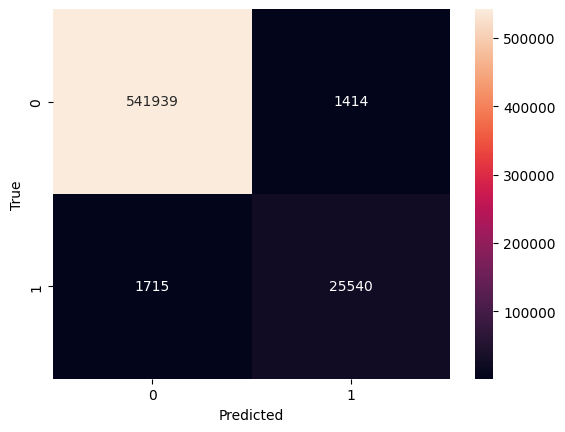

In [47]:
cm = confusion_matrix(predictions.label_ids, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Persist Results**

In [48]:
eval_results_dir = f"./results/{WANDB_RUN_NAME}"
os.makedirs(eval_results_dir, exist_ok=True)

Locally

In [49]:
report.to_csv(os.path.join(eval_results_dir, "classification_report.csv"))

# Save Confusion Matrix 
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(eval_results_dir, "confusion_matrix.png"))
plt.close()

To Wandb

In [50]:
metrics_to_log = {
    "eval/accuracy": report.loc["accuracy", "f1-score"],
    "eval/f1_weighted": report.loc["weighted avg", "f1-score"],
    "eval/f1_class_0": report.loc["0", "f1-score"],
    "eval/f1_class_1": report.loc["1", "f1-score"],
    "eval/recall_class_0": report.loc["0", "recall"],
    "eval/recall_class_1": report.loc["1", "recall"]
}

wandb.log(metrics_to_log)
wandb.log({
    "confusion_matrix": wandb.Image(os.path.join(eval_results_dir, "confusion_matrix.png"))
})

In [51]:
wandb.finish()

eval/accuracy,▁▁
eval/f1,▁
eval/f1_class_0,▁
eval/f1_class_1,▁
eval/f1_weighted,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/recall_class_0,▁
eval/recall_class_1,▁
eval/runtime,▁


# Baseline Model

Vectorize the sentence with TF-IDF and train a logistic regression model. Fast and interpretable + a classic ML baseline

In [52]:
train_df.head()

,question,context,target_sentence,target_index,label
0,1010 abdominal pain meds on in past,[START] this is a 59yearold female with a hist...,this is a 59yearold female with a history of r...,0,0
1,1010 abdominal pain meds on in past,this is a 59yearold female with a history of r...,she was given recent levaquin for an upper res...,1,0
2,1010 abdominal pain meds on in past,this is a 59yearold female with a history of r...,she complained of 1010 abdominal pain and was ...,2,1
3,1010 abdominal pain meds on in past,she was given recent levaquin for an upper res...,her hematocrit at one point required two units...,3,0
4,1010 abdominal pain meds on in past,she complained of 1010 abdominal pain and was ...,she was discharged on diltiazem 30 mg qid,4,0


In [53]:
train_baseline_texts = (train_df["question"] + " [SEP] " + train_df["target_sentence"]).tolist()
test_baseline_texts = (test_df["question"] + " [SEP] " + test_df["target_sentence"]).tolist()

In [54]:
train_labels = train_df["label"].tolist()
test_labels = test_df["label"].tolist()

In [55]:
from sklearn.pipeline import Pipeline

In [56]:
baseline_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

In [57]:
baseline_pipeline.fit(train_baseline_texts, train_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [58]:
test_preds = baseline_pipeline.predict(test_baseline_texts)
report = pd.DataFrame(classification_report(test_labels, test_preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.997177,0.845905,0.915333,543353.000000
1,0.236630,0.952266,0.379065,27255.000000
accuracy,0.850985,0.850985,0.850985,0.850985
macro avg,0.616903,0.899085,0.647199,570608.000000
weighted avg,0.960850,0.850985,0.889719,570608.000000


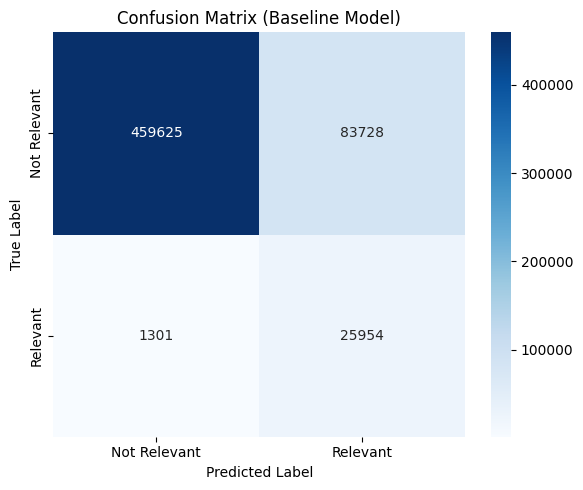

In [59]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
labels = ["Not Relevant", "Relevant"]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Baseline Model)")
plt.tight_layout()
plt.show()

In [57]:
baseline_eval_results_dir = "./results/Baseline"
os.makedirs(baseline_eval_results_dir, exist_ok=True)

In [58]:
report.to_csv(os.path.join(baseline_eval_results_dir, "classification_report.csv"))

# Save Confusion Matrix 
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(baseline_eval_results_dir, "confusion_matrix.png"))
plt.close()